# Disaster tweet classification

## Description

The goal of this mini project is to classify tweets based on whether they are talking about real disasters as part of the Kaggle competition at https://www.kaggle.com/competitions/nlp-getting-started/overview.  

The dataset consists of 7613 tweets that have been labeled as either disaster (1) or not disaster (0) related. The test data for evaluation consists of 3263 unlabeled tweets.  

The evaluation metric for the competition is the F1 score on the test set. F1 score is the harmonic mean of Precision and Recall.

Listing the formulas for Precision, Recall and F1 score below.

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

where TP is the number of true positives, FP the number of false positives, and FN the number of false negatives.


## EDA


Starting by loading the training and test datasets and looking at their structure and first few rows

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import models
from keras import layers
import tensorflow as tf

data_dir = '~/datasets/nlp-disaster-tweets'


In [2]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

train_df.info()
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


The `text` column contains the tweet text and the `target` column contains the labels. I am going to ignore the other columns and just use the text for classification. 

Looking at some sample rows in the training data.

In [3]:
print(train_df[['id', 'text', 'target']].sample(5))


        id                                               text  target
1834  2637  Army sources say 12 persons on board including...       1
1177  1694  #TrainTragedy - Happened in MP due to collapse...       1
1284  1852  burned 202 calories doing 30 minutes of Walkin...       0
158    226  DTN Brazil: Experts in France begin examining ...       1
3365  4820  Humboldt Cty Sheriff's Office has issued an ev...       1


I am now going to plot the distribution of the labels in in the training data to see if the dataset is balanced or not.

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


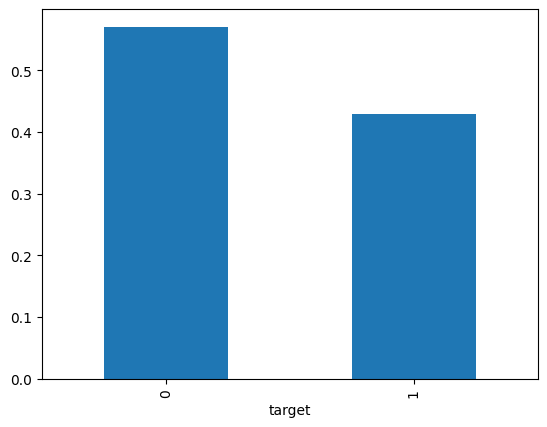

In [4]:
print(train_df['target'].value_counts(normalize=True))

train_df['target'].value_counts(normalize=True).plot(kind='bar')
plt.show()

Looks like the dataset is nearly balanced with around 57% of the tweets being non-disaster related and around 43% of the tweets being disaster related.

Now cleaning the text data by removing urls, html escape characters, punctuation, numbers and non-english characters and lower-casing the text.
I am also going to look at which words are common in each class using word clouds to see if there are any obvious patterns.

In [5]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import re


def clean_text(text):
    """
    Cleans text by removing urls, html escape characters, punctuation, numbers and non-english characters.
    Also removes stop words and lowercases the text. 
    """
    # Remove urls from text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove html escape characters
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', ' ', text)
    # Remove non-english characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase the text
    text = text.lower()

    text = ' '.join([word for word in text.split() 
                     if word not in ENGLISH_STOP_WORDS 
                     if word not in ['s', 're', 'm', 've', 't']])
    return text



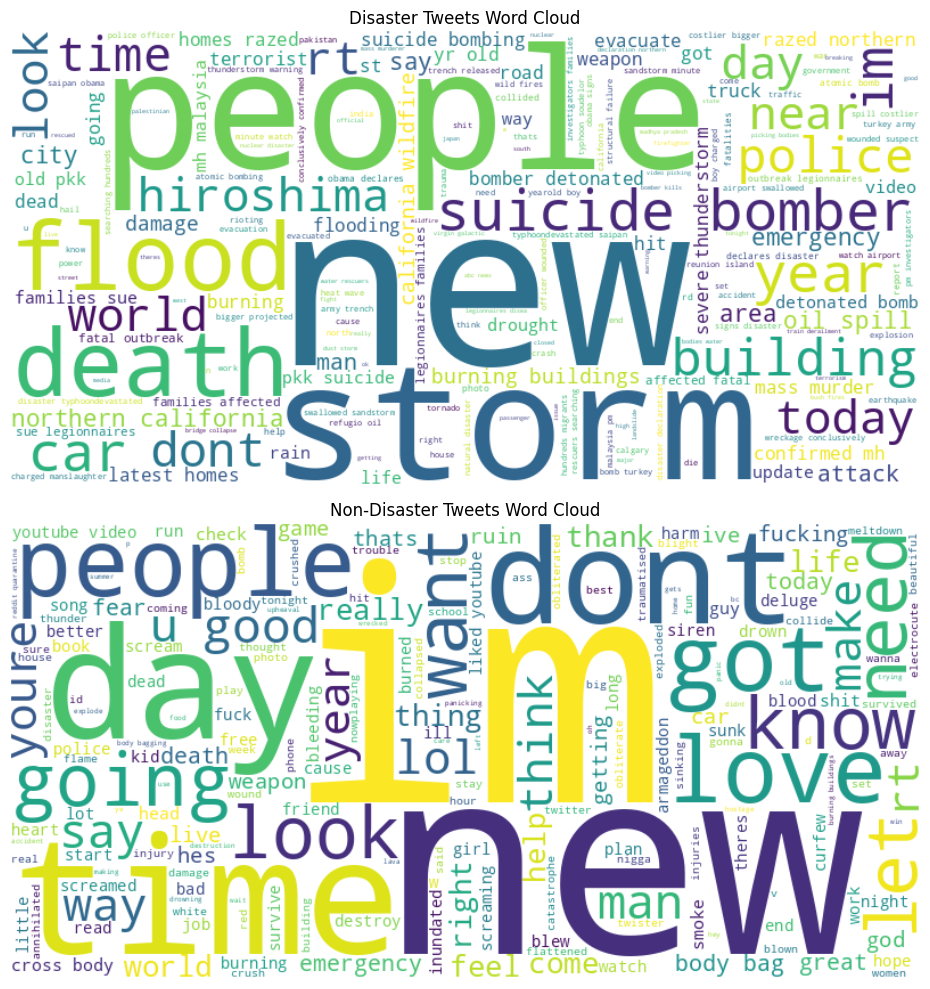

In [6]:
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'].apply(clean_text))
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['text'].apply(clean_text))

disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
non_disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

# Plotting wordclouds for disaster tweets and non-disaster tweets in training data
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweets Word Cloud')
ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non-Disaster Tweets Word Cloud')
plt.tight_layout()
plt.show()

Looks like disaster related words like suicide, bomber, death, news, emergency, storm, flood etc. are most common in disaster-related tweets compared to non-disaster related tweets. 

Now going to look at the vocabulary size of the training data. This will help in deciding on and tuning the word embeddings.


In [7]:
from collections import Counter

# Count the frequency of each word in the text
word_freq = Counter()
word_freq.update(disaster_text.split())
word_freq.update(non_disaster_text.split())
# Get the vocabulary size
vocab_size = len(word_freq)
print(f'Vocabulary size: {vocab_size}')

most_frequent_words = word_freq.most_common(10)
print(f'Most frequent words: {most_frequent_words}')

print(f'Maximum sequence length in training data: {train_df["text"].apply(clean_text).apply(lambda x: len(x.split())).max()}')
print(f'Maximum sequence length in test data: {test_df["text"].apply(clean_text).apply(lambda x: len(x.split())).max()}')


Vocabulary size: 16565
Most frequent words: [('like', 345), ('just', 320), ('im', 307), ('new', 226), ('dont', 208), ('news', 207), ('people', 197), ('video', 165), ('emergency', 157), ('disaster', 153)]
Maximum sequence length in training data: 21
Maximum sequence length in test data: 21


## Text Vectorization

I will use the TextVectorization layer from Keras to vectorize the text data. This layer will convert the text data into a sequence of integers, where each integer represents a word in the vocabulary. I will start with a vocabulary size of 10,000 and a maximum sequence length of 21 looking at the above analysis.

In [8]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [9]:

# Setting vocabulary to 15000 and max sequence length to 21
vocab_size = 15000
# Since I already cleaned the text, I will set the standardize parameter to None
text_vec_layer = layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=21, standardize=None)
text_vec_layer.adapt(train_df['text'].values)

print(f'Vocabulary size: {len(text_vec_layer.get_vocabulary())}')
print(text_vec_layer.get_vocabulary()[:10])

Vocabulary size: 15000
['', '[UNK]', np.str_('like'), np.str_('just'), np.str_('im'), np.str_('new'), np.str_('dont'), np.str_('news'), np.str_('people'), np.str_('video')]


2025-06-08 16:03:44.623625: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-08 16:03:44.623697: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-08 16:03:44.623721: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1749378824.623741   14183 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749378824.623764   14183 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
print(train_df['text'].values[:3])
text_vec_layer(train_df['text'].values[:3])

['deeds reason earthquake allah forgive'
 'forest near la ronge sask canada'
 'residents asked shelter place notified officers evacuation shelter place orders expected']


<tf.Tensor: shape=(3, 21), dtype=int64, numpy=
array([[ 5742,   656,   125,  1460,  5491,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [   76,   106,   497,  8807,  8615,  1214,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [ 1510,  1455,  1901,   508, 10187,  1531,   124,  1901,   508,
         1171,   910,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])>

Looking at the output of text vectorization layer, we can an see that the text data has been converted into a sequence of integers.  

Now the integers assigned to the words are arbitrary and this is not a good representation of the text data. We need to convert these integers into a meaningful representation. This can be done using an embedding layer. With word embeddings, we can convert the integers into a dense vector representation of the words. Similar words will have similar vector representations.

I will create an embedding layer and see how it works.

In [11]:
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=64)
embedding_layer(text_vec_layer(train_df['text'].values[:3]))

<tf.Tensor: shape=(3, 21, 64), dtype=float32, numpy=
array([[[ 0.04228259,  0.04172594, -0.00030972, ..., -0.04962982,
         -0.02151953, -0.01570513],
        [ 0.0494727 ,  0.02052982, -0.02346903, ...,  0.01808139,
          0.03496106, -0.01859816],
        [-0.03428327, -0.0033986 , -0.01363944, ...,  0.04375956,
         -0.0229051 ,  0.03521103],
        ...,
        [ 0.00125588, -0.02694818, -0.02478415, ...,  0.00609907,
         -0.03440622, -0.02284027],
        [ 0.00125588, -0.02694818, -0.02478415, ...,  0.00609907,
         -0.03440622, -0.02284027],
        [ 0.00125588, -0.02694818, -0.02478415, ...,  0.00609907,
         -0.03440622, -0.02284027]],

       [[-0.02638687,  0.00322036,  0.04250992, ...,  0.01616039,
         -0.01425278, -0.01947373],
        [-0.0448313 , -0.02997776, -0.00491835, ...,  0.01118615,
          0.01062502, -0.00464276],
        [ 0.0015622 ,  0.04010789, -0.00030019, ..., -0.04008896,
         -0.0297771 , -0.04776717],
        ...,
 

As we can see, the integers are converted into 64 dimensional vectors. 

## Model architecture

Now I will use these vector embeddings to train a model and see how it performs. I will start with a simple LSTM model and see if adding more layers or using bidirectional LSTM improves the performance. I will also try to see how a GRU model performs compared to LSTM. 

First defining a few functions to help train models and plot training histories.

In [12]:
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy against the number of epochs.
    Parameters:
    - history: History object returned by the fit method of a Keras model
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    

def train_model(model, model_name, X, y, epochs=100, batch_size=32, validation_split=0.2,
                optimizer='Adam', loss='binary_crossentropy',
                plot_history=True):
    """
    Trains a Keras model with the given data and saves the best weights based on validation AUC.
    Stops early if there is no improvement in validation AUC for 10 epochs.
    Using validation AUC for calculating best weights as this is the scoring critieria
    for the kaggle competition.
    Parameters:
    - model: Keras model to train.
    - model_name: String, name of the model used for naming the weights file.
    - X: Training data.
    - y: Training labels.
    - epochs: Integer, number of epochs to train.
    - batch_size: Integer, batch size for training.
    - validation_split: Float, fraction of data to use for validation.
    - optimizer: Keras optimizer.
    - loss: Keras loss function.
    - plot_history: Boolean, whether to plot the training history.
    Returns:
    - Trained Keras model with the best weights loaded.
    """

    # Figure out how to integrate F1Score into the metrics
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', keras.metrics.F1Score(threshold=0.5)])
    checkpointer = keras.callbacks.ModelCheckpoint(
        f'{model_name}.best_weights.keras', 
        save_best_only=True,
        verbose=1,
        monitor='val_f1_score',
        mode='max')
    early_stopping = keras.callbacks.EarlyStopping(
        patience=5,
        verbose=1) 

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                        callbacks=[checkpointer, early_stopping])
    
    if plot_history:
        plot_training_history(history)

    model.load_weights(f'{model_name}.best_weights.keras')
    return model # , history

 
def evaluate_model_and_print_results(model, X_test, y_test):
    """
    Evaluates the model on the test data and prints the results.
    Parameters:
    - model: Keras model to evaluate.
    - X_test: Test data.
    - y_test: Test labels.
    """
    test_loss, test_accuracy, test_f1score = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test F1 Score: {test_f1score}')

### Simple LSTM model with dropout



In [13]:
# LSTM model
model = models.Sequential([
    layers.InputLayer(shape=train_df['text'].values.shape[1:], dtype=tf.string),
    text_vec_layer,
    embedding_layer,
    layers.LSTM(50),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
]) 

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 21)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 21, 64)         │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 985,601 (3.76 MB)

 Trainable params: 985,601 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-06-08 16:03:45.366402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5897 - f1_score: 0.2717 - loss: 0.6642
Epoch 1: val_f1_score improved from -inf to 0.75545, saving model to lstm_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5901 - f1_score: 0.2727 - loss: 0.6639 - val_accuracy: 0.7938 - val_f1_score: 0.7555 - val_loss: 0.4610
Epoch 2/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8774 - f1_score: 0.8445 - loss: 0.3212
Epoch 2: val_f1_score improved from 0.75545 to 0.76900, saving model to lstm_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8773 - f1_score: 0.8444 - loss: 0.3214 - val_accuracy: 0.7945 - val_f1_score: 0.7690 - val_loss: 0.4643
Epoch 3/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9341 - f1_score: 0.9199 - loss: 0.2086
Epoch 3: val_f1_score did not improve from 0.76900
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9341 - f1_score: 0.9198 - loss: 0.2086 - val_accuracy: 0.7794 - v

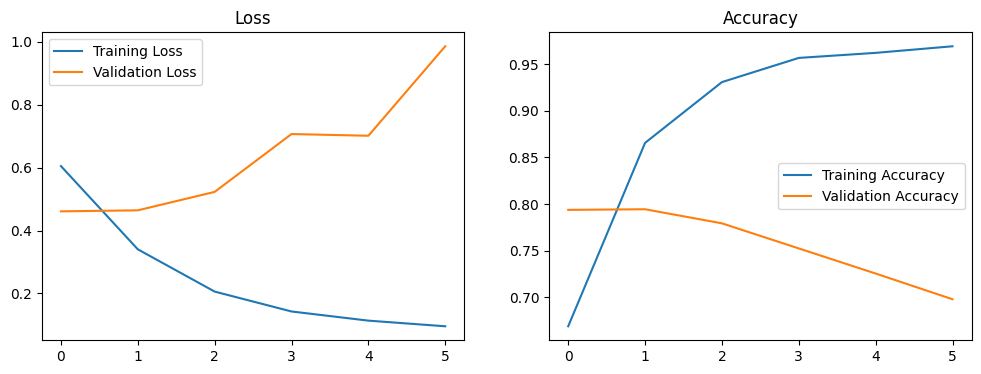

In [14]:
model = train_model(model, 'lstm_model', train_df['text'].values, train_df['target'],
                    epochs=20, batch_size=32) 

In [15]:
Ypred = model.predict(test_df['text'].values)
Ypred = np.round(Ypred).astype(int)
test_df['target'] = Ypred
test_df.to_csv('nlp_disaster_tweets_submission_lstm_simple.csv', columns=['id', 'target'], index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Seems like even this simple model is overfitting a bit. My score on the kaggle leaderboard is 0.79313 for this model on the test data.  
I will see if I can improve this with a bidirectional LSTM model.

### Bidirectional LSTM model



In [ ]:
# Bidirectional LSTM model
model2 = models.Sequential([
    layers.InputLayer(shape=train_df['text'].values.shape[1:], dtype=tf.string),
    text_vec_layer,
    layers.Embedding(input_dim=vocab_size, output_dim=64),
    layers.Bidirectional(layers.LSTM(50)),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
]) 

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 21)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 21, 64)         │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100)            │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,101 (3.86 MB)

 Trainable params: 1,011,101 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

: 

In [ ]:
model2 = train_model(model2, 'lstm_model_bidirectional', train_df['text'].values, train_df['target'],
                    epochs=100, batch_size=32, optimizer=keras.optimizers.Adam(learning_rate=0.0001)) 

Epoch 1/100


In [ ]:
Ypred = model2.predict(test_df['text'].values)
Ypred = np.round(Ypred).astype(int)
test_df['target'] = Ypred
test_df.to_csv('nlp_disaster_tweets_submission_lstm_bidirectional.csv', columns=['id', 'target'], index=False)

In [ ]:
# GRU model
model3 = models.Sequential([
    layers.InputLayer(shape=train_df['text'].values.shape[1:], dtype=tf.string),
    text_vec_layer,
    layers.Embedding(input_dim=vocab_size, output_dim=64),
    layers.GRU(50),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
]) 

model3.summary()

In [ ]:
model3 = train_model(model3, 'gru_model', train_df['text'].values, train_df['target'],
                    epochs=100, batch_size=32, optimizer=keras.optimizers.Adam(learning_rate=0.0001)) 

In [ ]:
Ypred = model3.predict(test_df['text'].values)
Ypred = np.round(Ypred).astype(int)
test_df['target'] = Ypred
test_df.to_csv('nlp_disaster_tweets_submission_gru.csv', columns=['id', 'target'], index=False)